In [1]:
import pandas as pd
import numpy as np
import pickle

In [40]:
#train_region = "Austin"
#test_region = "SanDiego"
test_region = "SanDiego"
train_region = "Austin"
out_overall = pickle.load(open('../data/input/all_regions.pkl','r'))

train_df = out_overall[train_region]
test_df = out_overall[test_region]
#transform = "DD"
best_transform = {}

best_transform['SanDiego']={'fridge': 'DD', 'hvac': 'DD-percentage', 'wm': 'median-aggregate-percentage'}
best_transform['Austin']={'fridge': 'regional', 'hvac': 'DD-percentage', 'wm': 'regional'}
#transformations = ['DD','None',"DD-fridge"]

In [41]:
out = {}
for appliance in ['fridge','hvac','wm']:
    out[appliance] = {}
    transform = best_transform[test_region][appliance]
    if appliance=="hvac":
        start, stop=5,11
    else:
        start, stop=1,13
    for k in range(1,6):
        print appliance, k
        out[appliance][k] = {}
        
        for month in range(start,stop):
            out[appliance][k][month] = []
            for test_home in test_df.index:
                try:
                    pred =  pickle.load(open('../data/output/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                                               test_region,
                                                                                               transform,
                                                                                               appliance,
                                                                                               month,
                                                                                               test_home,
                                                                                               k),'r'))
                    gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                    error = np.abs(gt-pred)
                    percentage_error = error*100/gt
                    if percentage_error>100:
                        percentage_error=100
                    percentage_accuracy = 100-percentage_error
                    out[appliance][k][month].append(percentage_accuracy)
                except Exception, e:
                    pass
            out[appliance][k][month] = pd.Series(out[appliance][k][month]).mean()
        out[appliance][k] = pd.Series(out[appliance][k]).mean()
            

            


fridge 1
fridge 2
fridge 3
fridge 4
fridge 5
hvac 1
hvac 2
hvac 3
hvac 4
hvac 5
wm 1
wm 2
wm 3
wm 4
wm 5


In [48]:
import sys
sys.path.append("../code/")

In [49]:
from common_functions import latexify, format_axes, tableau20blind

In [50]:
out_df = pd.DataFrame(out)

In [51]:
%matplotlib inline
import matplotlib.pyplot as plt

In [52]:
latexify()

In [53]:
out_df.columns = ['Fridge','HVAC','Washing\nmachine']

In [54]:
train_region

'Austin'

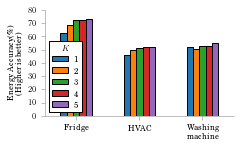

In [55]:
ax = out_df.T.plot(kind="bar",rot=0, colors=tableau20blind[::2])
ax.legend(loc=3, title='$K$')
format_axes(ax)
plt.ylabel("Energy Accuracy(\%)\n(Higher is better)")
plt.tight_layout()
plt.ylim((0,80))
plt.savefig('../results/cross_sensitivity_%s_%s.pdf' %(train_region, test_region),bbox_inches="tight")
plt.savefig('../results/cross_sensitivity_%s_%s.png' %(train_region, test_region),bbox_inches="tight")


In [37]:
out_df

,Fridge,HVAC,Washing machine
1,66.781996,59.477381,46.155657
2,68.779981,63.007002,47.179987
3,69.439168,63.868075,47.385747
4,69.339672,64.213379,47.602324
5,69.198541,64.107408,47.954194


In [122]:
acc = {tr:{} for tr in transformations}

#acc['Regional average']={}

for transform in transformations:
    #for appliance in ["hvac","fridge","wm"]:
    for appliance in ["hvac",'fridge','wm']:    
        acc[transform][appliance] = {}
        for month in range(1,13):
            acc[transform][appliance][month] = pd.Series(out[transform][appliance][month]).mean()

In [123]:
%matplotlib inline

In [124]:
import matplotlib.pyplot as plt

In [125]:
import sys
sys.path.append('../code/')


In [126]:
from common_functions import latexify, format_axes, tableau20blind

hvac (None, Energy)                    35.887247
(Degree days, Energy)             45.453343
(Degree days, Proportion)         51.271054
(Median aggregate, Energy)        36.512030
(Median aggregate, Proportion)    35.371369
(Regional average, Energy)              NaN
(Regional average, Proportion)    39.850926
dtype: float64
fridge (None, Energy)                    70.037198
(Degree days, Energy)             72.158610
(Degree days, Proportion)         71.952065
(Median aggregate, Energy)        51.037447
(Median aggregate, Proportion)    57.871978
(Regional average, Energy)              NaN
(Regional average, Proportion)    66.083300
dtype: float64
wm (None, Energy)                    51.060758
(Degree days, Energy)             49.430957
(Degree days, Proportion)         44.070146
(Median aggregate, Energy)        48.053898
(Median aggregate, Proportion)    53.063354
(Regional average, Energy)              NaN
(Regional average, Proportion)    51.136766
dtype: float64


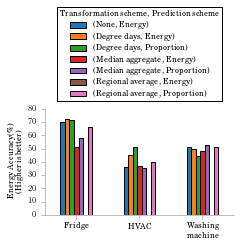

In [127]:
#for i, appliance in enumerate(["hvac","fridge","wm"]):
out_tr = {}
for i, appliance in enumerate(["hvac","fridge","wm"]):
    if appliance =="hvac":
        start, stop=5, 11
    else:
        start, stop = 1, 13
    ap_dict = {approach:acc[approach][appliance] for approach in acc.keys()}
    df = pd.DataFrame(ap_dict)
    df = df[transformations].ix[range(start, stop)]
    df.columns = [('None','Energy'),('Degree days','Energy'),('Degree days','Proportion'),
              ('Median aggregate','Energy'),('Median aggregate','Proportion'),
             ('Regional average','Energy'),('Regional average','Proportion')]
    out_tr[appliance] = df.mean()
    print appliance, df.mean()
latexify()
out_df = pd.DataFrame(out_tr).T
out_df.index = ['Fridge','HVAC','Washing\nmachine']
ax = out_df.plot(kind="bar", legend=False, rot=0, colors=tableau20blind[::2])
lgd=ax.legend(bbox_to_anchor=(0.5,2), loc='upper center', ncol=1, title=('Transformation scheme, Prediction scheme'))
plt.ylabel("Energy Accuracy(\%)\n(Higher is better)")

format_axes(ax)

plt.tight_layout()
#df.plot(ax=ax[i], kind='bar', title=appliance, rot= 0, legend=False)
#plt.tight_layout()
#lgd=ax[0].legend(bbox_to_anchor=(0.5,2.2), loc='upper center', ncol=1)
#plt.xlabel("Month")
plt.savefig('../results/sensitivity_transform_%s_%s.png' %(train_region, test_region),bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('../results/sensitivity_transform_%s_%s.pdf' %(train_region, test_region),bbox_extra_artists=(lgd,), bbox_inches='tight')

In [114]:
out_df

,"(None, Energy)","(Degree days, Energy)","(Degree days, Proportion)","(Median aggregate, Energy)","(Median aggregate, Proportion)","(Regional average, Energy)","(Regional average, Proportion)"
fridge,67.690543,68.776598,46.435586,19.880803,22.502139,69.439168,48.990562
hvac,42.738050,55.167269,63.868075,50.293532,NaN,45.371368,51.271047
wm,47.220397,47.301504,22.799496,22.452607,21.082159,47.385747,25.688978


In [98]:
df.columns = [('None','Energy'),('Degree days','Energy'),('Degree days','Proportion'),
              ('Median aggregate','Energy'),('Median aggregate','Proportion'),
             ('Regional average','Energy'),('Regional average','Proportion')]

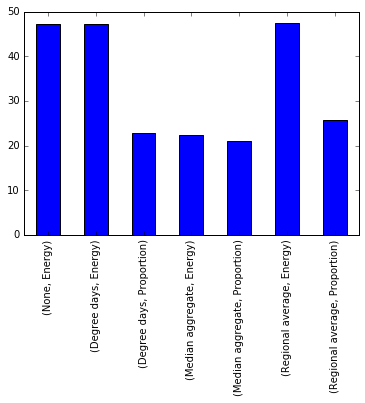

In [102]:
df.mean().plot(kind="bar")

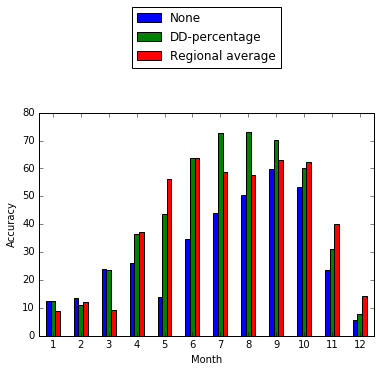

In [375]:
df.plot(kind="bar",rot=0)
plt.xlabel("Month")
plt.ylabel("Accuracy")
lgd=plt.legend(bbox_to_anchor=(0.5,1.5), loc='upper center', ncol=1)
plt.savefig('../results/dd_transform_sd_austin_hvac.png',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [369]:
df.ix[range(5,11)].mean()

DD                  55.167269
None                42.738050
median-aggregate    50.293532
DD-percentage       63.868075
regional            45.371368
dtype: float64

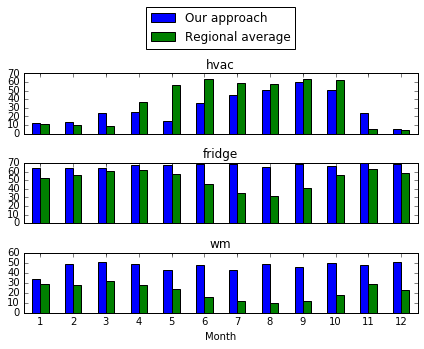

In [157]:
from IPython.display import Image
Image('../results/no_transform_sd_austin.png')

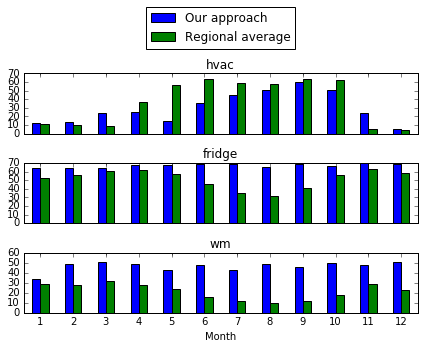

In [119]:
fig, ax = plt.subplots(nrows=3, sharex=True)
for i, appliance in enumerate(["hvac","fridge","wm"]):
    ap_dict = {approach:acc[approach][appliance] for approach in acc.keys()}
    df = pd.DataFrame(ap_dict)
    df.plot(ax=ax[i], kind='bar', title=appliance, rot= 0, legend=False)
plt.tight_layout()
lgd=ax[0].legend(bbox_to_anchor=(0.5,2.2), loc='upper center', ncol=1)
plt.xlabel("Month")
#

#plt.savefig('../results/no_transform_sd_austin.png',bbox_extra_artists=(lgd,), bbox_inches='tight')

In [73]:
ap_dict

{'Our approach': {1: 33.8734504582082,
  2: 48.67136857405774,
  3: 50.31158734130758,
  4: 48.937788635189555,
  5: 42.91586645201225,
  6: 47.54102296541092,
  7: 42.690949812235495,
  8: 48.85646634271478,
  9: 45.31713598166896,
  10: 49.332064873332705,
  11: 47.12320106158118,
  12: 50.861510015694236},
 'Regional average': {1: 33.8734504582082,
  2: 48.67136857405774,
  3: 50.31158734130758,
  4: 48.937788635189555,
  5: 42.91586645201225,
  6: 47.54102296541092,
  7: 42.690949812235495,
  8: 48.85646634271478,
  9: 45.31713598166896,
  10: 49.332064873332705,
  11: 47.12320106158118,
  12: 50.861510015694236}}

In [77]:
acc['Regional average']

{'fridge': {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: []},
 'hvac': {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: []},
 'wm': {1: [],
  2: [],
  3: [],
  4: [],
  5: [],
  6: [],
  7: [],
  8: [],
  9: [],
  10: [],
  11: [],
  12: []}}

In [129]:
train_df['hvac_9'].mean()

218.4750300575705

In [128]:
test_df['hvac_9'].mean()

482.0247721723813

In [245]:
m = {}
for transform in transformations:
    m[transform] = {}
    for appliance in ["fridge"]:
       
        for month in range(1,13):
            m[transform][month]=[]
            
            out[transform][appliance][month] = []
            for test_home in test_df.index:
                try:
                    pred =  pickle.load(open('../data/output/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                                               test_region,
                                                                                               transform,
                                                                                               appliance,
                                                                                               month,
                                                                                               test_home,
                                                                                               k),'r'))
                    gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                    error = np.abs(gt-pred)
                    percentage_error = error*100/gt
                    if percentage_error>100:
                        percentage_error=100
                    percentage_accuracy = 100-percentage_error
                    #print appliance, month, transform, gt-pred
                    m[transform][month].append(gt-pred)
                except Exception, e:
                    pass

            


In [246]:
pd.Series(m['DD'][7]).describe()

count    299.000000
mean       6.553594
std       32.121251
min      -57.424472
25%       -9.852161
50%        2.342088
75%       14.932602
max      328.898272
dtype: float64

In [247]:
a = {}
for transform in transformations:
    a[transform] = {}
    for month in range(1,13):
        a[transform][month] = pd.Series(m[transform][month]).mean()
    
    

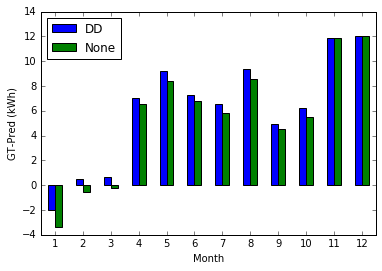

In [250]:
pd.DataFrame(a)[['DD','None']].plot(kind="bar",rot=0)
plt.xlabel("Month")
plt.ylabel("GT-Pred (kWh)")
#plt.savefig('../results/transform_strategy_hvac.png')

In [243]:
train_df['fridge_11'].mean(), test_df['fridge_11'].mean()

(36.504466090883525, 54.91064814108161)

46.137905111303894

In [347]:
out = {}
for transform in transformations:
    out[transform] = {}
    #for appliance in ["hvac","fridge","dr","wm"]:
    for appliance in ['hvac']:
        out[transform][appliance] = {}
        for month in range(1,13):
            print appliance, month, transform
            out[transform][appliance][month] = []
            for test_home in test_df.index:
                try:
                    pred =  pickle.load(open('../data/output/ineq_cross/%s_%s_%s_%s_%d_%d_%d.pkl' %(train_region,
                                                                                               test_region,
                                                                                               transform,
                                                                                               appliance,
                                                                                               month,
                                                                                               test_home,
                                                                                               k),'r'))
                    gt = test_df.ix[test_home]['%s_%d' %(appliance, month)]
                    error = np.abs(gt-pred)
                    
                    out[transform][appliance][month].append(error)
                except Exception, e:
                    pass

            


hvac 1 DD
hvac 2 DD
hvac 3 DD
hvac 4 DD
hvac 5 DD
hvac 6 DD
hvac 7 DD
hvac 8 DD
hvac 9 DD
hvac 10 DD
hvac 11 DD
hvac 12 DD
hvac 1 None
hvac 2 None
hvac 3 None
hvac 4 None
hvac 5 None
hvac 6 None
hvac 7 None
hvac 8 None
hvac 9 None
hvac 10 None
hvac 11 None
hvac 12 None
hvac 1 median-aggregate
hvac 2 median-aggregate
hvac 3 median-aggregate
hvac 4 median-aggregate
hvac 5 median-aggregate
hvac 6 median-aggregate
hvac 7 median-aggregate
hvac 8 median-aggregate
hvac 9 median-aggregate
hvac 10 median-aggregate
hvac 11 median-aggregate
hvac 12 median-aggregate
hvac 1 DD-percentage
hvac 2 DD-percentage
hvac 3 DD-percentage
hvac 4 DD-percentage
hvac 5 DD-percentage
hvac 6 DD-percentage
hvac 7 DD-percentage
hvac 8 DD-percentage
hvac 9 DD-percentage
hvac 10 DD-percentage
hvac 11 DD-percentage
hvac 12 DD-percentage


In [348]:
acc = {tr:{} for tr in transformations}

acc['Regional average']={}

for transform in transformations:
    #for appliance in ["hvac","fridge","wm"]:
    for appliance in ["hvac"]:    
        acc[transform][appliance] = {}
        for month in range(1,13):
            acc[transform][appliance][month] = pd.Series(out[transform][appliance][month]).median()

,DD,DD-percentage,None,Regional average,median-aggregate
hvac,"{1: 8.44147178069, 2: 57.656674514, 3: 44.0356...","{1: 12.0296812273, 2: 48.8202568568, 3: 44.856...","{1: 2.92191117009, 2: 16.5883969124, 3: 42.407...",NaN,"{1: 1.22682088274, 2: 4.71549728458, 3: 40.347..."


In [354]:
pd.Series(acc['DD-percentage']['hvac'])

1     12.029681
2     48.820257
3     44.856039
4     55.901814
5     92.348637
6     81.464455
7     82.482646
8     79.634070
9     71.332982
10    68.626646
11    19.807754
12     7.320005
dtype: float64

In [355]:
pd.Series(acc['None']['hvac'])

1       2.921911
2      16.588397
3      42.407613
4      64.840691
5     155.903642
6     202.587438
7     330.707652
8     326.625814
9     148.695028
10     87.474467
11     21.282795
12      8.047367
dtype: float64